## Part 02: Export nodes and select working streets
michael babb  
2024 11 24

In [71]:
# standard
import os
import collections

In [72]:
# external
from concave_hull import concave_hull
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely

In [73]:
# custom
import run_constants as rc
from utils import create_name, generate_street_end_vertices, write_gdf, write_json

# load the street network

In [74]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S02_SND_IN_FILE_NAME)

In [75]:
gdf = gpd.read_file(filename = fpn)

In [76]:
gdf.shape

(34378, 39)

In [77]:
gdf['ord_stname_unique'].unique().shape

(3696,)

# generate street end vertices - these will be helpful with identification in subsequent steps

In [78]:
# can we generate the vertices? yes... but let's check what type of geometry we are working with
gdf['geometry'].map(lambda x: x.geom_type).value_counts()

geometry
MultiLineString    34378
Name: count, dtype: int64

In [79]:
# everything is a MultLineString??? is that necessary?
# we can call the gdf.explode() function to convert MultiLineStrings to LineStrings
# if the record counts are the same, we can convert everything to LineStrings 
test_gdf = gdf.explode()

In [80]:
test_gdf.shape

(34378, 39)

In [81]:
# nope! The number of records is the same, indicating that MultiLineStrings are not necessary
gdf = test_gdf.copy()

In [82]:
gdf['geometry'].geom_type.value_counts()

LineString    34378
Name: count, dtype: int64

In [83]:
gdf, node_gdf = generate_street_end_vertices(gdf = gdf)

In [84]:
write_gdf(gdf = node_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name= rc.S02_NODE_OUT_FILE_NAME)

# import the manually classified streets to update streets without a classification. 

In [85]:
fpn = os.path.join(rc.INPUT_FILE_PATH, rc.S02_BST_IN_FILE_NAME)

In [86]:
blank_street_type_df = pd.read_excel(io = fpn)

In [87]:
blank_street_type_df.head()

,ord_stname_concat,ord_street_type_fix
0,17TH AVE NW WKWY,WKWY
1,21ST AV SW TURN,RN
2,59TH AV SW TURN,ST
3,AIRPORT FY NB,SR
4,AIRPORT FY SB,SR


In [88]:
blank_street_type_df.shape

(80, 2)

In [89]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'citycode',
       'stname_id', 'st_code', 'arterial_code', 'segment_type', 'agency_code',
       'access_code', 'divided_code', 'structure_type', 'legalloc_code',
       'vehicle_use_code', 'gis_seg_length', 'l_adrs_from', 'l_adrs_to',
       'r_adrs_from', 'r_adrs_to', 'ord_pre_dir', 'ord_street_name',
       'ord_street_type', 'ord_suf_dir', 'ord_stname_concat', 'l_city',
       'l_state', 'l_zip', 'r_city', 'r_state', 'r_zip', 'sndseg_update',
       'compkey', 'comptype', 'unitid', 'unitid2', 'city_portion',
       'ord_stname_unique', 'geometry'],
      dtype='object')

In [90]:
test_join = pd.merge(left = gdf, right = blank_street_type_df, how = 'outer', indicator = True)

In [91]:
test_join['_merge'].value_counts()

_merge
left_only     33662
both            716
right_only        0
Name: count, dtype: int64

In [92]:
gdf = test_join.copy()

In [93]:
gdf.loc[gdf['ord_street_type'].isna(), 'ord_street_type'] = gdf.loc[gdf['ord_street_type'].isna(), 'ord_street_type_fix']

In [94]:
gdf['ord_street_type'].unique()

array(['RP', 'AVE', 'LN', 'PL', 'TER', 'RD', 'CT', 'BR', 'WKWY', 'TRL',
       'RN', 'ST', 'ET', 'DR', 'CIR', 'PKWY', 'SR', 'WAY', 'AL', 'RR',
       'BLVD', 'OP', 'STCR', 'IS', 'MALL', 'PZ', 'LOOP', 'FLYOVER',
       'VIEW', 'HWY'], dtype=object)

In [95]:
gdf['ord_street_type'].isna().value_counts()

ord_street_type
False    34378
Name: count, dtype: int64

In [96]:
gdf = gdf.drop(labels = ['ord_street_type_fix', '_merge'], axis = 1)

# keep only streets in Seattle

In [97]:
gdf = gdf.loc[(gdf['l_city'] == 'SEATTLE') |
(gdf['r_city'] == 'SEATTLE'), :].copy()

In [98]:
gdf.shape

(27891, 39)

In [99]:
gdf['ord_stname_concat'].unique().shape

(2795,)

# write the full seattle streets to disk

In [100]:
write_gdf(gdf = gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S02_SND_FULL_OUT_FILE_NAME)

# keep only streets with segment_type == 1  
These are actual streets.  
Everything else not a street (rail, trail, staircase, etc...).  
`segment_type == 15` is a stub, a dangling piece of a street, usually around 50 feet or less.  
Very short! There are 362 of them.

In [101]:
gdf['segment_type'].value_counts()

segment_type
1     25789
15      362
7       350
6       332
4       215
3       205
8       203
9       175
13      126
2        49
5        45
11       33
10        5
12        1
14        1
Name: count, dtype: int64

In [102]:
# before...
gdf.shape

(27891, 39)

In [103]:
gdf = gdf.loc[gdf['segment_type'] == 1, :].copy()
# after...
gdf.shape

(25789, 39)

In [104]:
gdf['ord_stname_unique'].unique().shape

(2462,)

# update the city portion variable

In [105]:
# we can quickly identify the central streets by performing some analysis in qGIS, 
fpn = os.path.join(rc.INPUT_FILE_PATH, rc.S02_CENTRAL_STREETS_IN_FILE_NAME)
cs_df = pd.read_csv(filepath_or_buffer=fpn)


In [106]:
# check
cs_df.head()

,snd_id,temp_city_portion
0,11524,CNTR
1,16184,CNTR
2,16185,CNTR
3,16187,CNTR
4,16289,CNTR


In [107]:
# join
test_join = pd.merge(left = gdf, right = cs_df, how = 'outer', indicator = True)
test_join['_merge'].value_counts()

_merge
left_only     24082
both           1707
right_only        0
Name: count, dtype: int64

In [108]:
test_join['ord_stname_unique'].unique().shape

(2462,)

In [109]:
check_df = test_join[['ord_stname_unique', 'city_portion']].drop_duplicates()

In [110]:
my_counter = collections.Counter(check_df['ord_stname_unique'])

In [111]:
test_join.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'citycode',
       'stname_id', 'st_code', 'arterial_code', 'segment_type', 'agency_code',
       'access_code', 'divided_code', 'structure_type', 'legalloc_code',
       'vehicle_use_code', 'gis_seg_length', 'l_adrs_from', 'l_adrs_to',
       'r_adrs_from', 'r_adrs_to', 'ord_pre_dir', 'ord_street_name',
       'ord_street_type', 'ord_suf_dir', 'ord_stname_concat', 'l_city',
       'l_state', 'l_zip', 'r_city', 'r_state', 'r_zip', 'sndseg_update',
       'compkey', 'comptype', 'unitid', 'unitid2', 'city_portion',
       'ord_stname_unique', 'geometry', 'temp_city_portion', '_merge'],
      dtype='object')

In [112]:
test_join.loc[test_join['_merge'] == 'both', 'city_portion'] = \
test_join.loc[test_join['_merge'] == 'both', 'temp_city_portion']

In [113]:
test_join['ord_stname_unique'] = test_join.apply(func = create_name, axis = 1)

In [114]:
# drop and overwrite
drop_col_names = ['temp_city_portion', '_merge']
gdf = test_join.drop(labels = drop_col_names, axis = 1).copy()

In [115]:
write_gdf(gdf = test_join, output_file_path = rc.OUTPUT_FILE_PATH, output_file_name='test_fucker.gpkg')

# draw a convex hull around each group of city streets

In [116]:
from shapely import Point, MultiPoint

In [117]:
data_list = []
geom_list = []
for cp in gdf['city_portion'].unique().tolist():
    print(cp)
    temp_geoms = gdf.loc[gdf['city_portion'] == cp, 'geometry']
    
    # create the convex hull around the points
    #geoms = shapely.unary_union(geometries = temp_geoms)
    geom_point_list = []
    point_list = []
    for curr_line in temp_geoms:
        for curr_coords in curr_line.coords:
            geom_point_list.append(Point(curr_coords))
            point_list.append(curr_coords)
    
    cvx_hull = shapely.convex_hull(geometry = MultiPoint(geom_point_list))
    print(type(cvx_hull))
    
    temp_list = [cp, 'convex']
    data_list.append(temp_list)
    geom_list.append(cvx_hull)

    # create a concave hull
    #point_list = [] 
    #for curr_line in temp_geoms:
    #    for curr_coords in curr_line.coords:
    #        point_list.append(curr_coords)
    # create a concave hull
    ch = concave_hull(points = point_list)
    my_poly = shapely.Polygon(ch)
    data_list.append([cp, 'concave'])
    geom_list.append(my_poly)

NW
<class 'shapely.geometry.polygon.Polygon'>
N
<class 'shapely.geometry.polygon.Polygon'>
NE
<class 'shapely.geometry.polygon.Polygon'>
CNTR
<class 'shapely.geometry.polygon.Polygon'>
E
<class 'shapely.geometry.polygon.Polygon'>
W
<class 'shapely.geometry.polygon.Polygon'>
S
<class 'shapely.geometry.polygon.Polygon'>
SW
<class 'shapely.geometry.polygon.Polygon'>


In [118]:
# build a geodataframe
output_gdf = gpd.GeoDataFrame(data = data_list, columns = ['city_portion', 'hull_type'], geometry = geom_list, crs = 'epsg:4326')
# fix any odd geometries
output_gdf['geometry'] = output_gdf['geometry'].make_valid()

In [119]:
output_gdf.head()

,city_portion,hull_type,geometry
0,NW,convex,"POLYGON ((-122.35768 47.65214, -122.35784 47.6..."
1,NW,concave,"MULTIPOLYGON (((-122.35728 47.65773, -122.3575..."
2,N,convex,"POLYGON ((-122.33299 47.61852, -122.33427 47.6..."
3,N,concave,"MULTIPOLYGON (((-122.35769 47.64955, -122.3576..."
4,NE,convex,"POLYGON ((-122.3046 47.64749, -122.31007 47.64..."


In [ ]:
# TODO: fix the multi polygon issue

In [62]:
# okay, cool. We have the lines. So, let's go back to the polygons. 
p_gdf = output_gdf.copy()

In [63]:
# save it!
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S02_CITY_SECTIONS_OUT_FILE_NAME)

In [64]:
# let's export this to a LineString file as well
output_gdf['geometry'] = output_gdf['geometry'].boundary
output_gdf['geometry'] = output_gdf['geometry'].make_valid()

In [65]:
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH, 
          output_file_name=rc.S02_CITY_SECTIONS_LINES_OUT_FILE_NAME)

In [66]:
# let's get weird with buffers

In [67]:
# keep only the concave bulls
p_gdf = p_gdf.loc[p_gdf['hull_type'] == 'concave', :]

<Axes: >

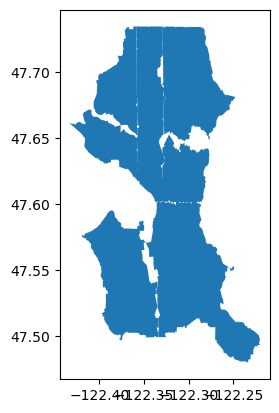

In [68]:
p_gdf.plot()

In [69]:
p_gdf.head()

,city_portion,hull_type,geometry
1,NW,concave,"MULTIPOLYGON (((-122.35728 47.65773, -122.3575..."
3,N,concave,"MULTIPOLYGON (((-122.35769 47.64955, -122.3576..."
5,NE,concave,"POLYGON ((-122.32833 47.65794, -122.3282 47.65..."
7,CNTR,concave,"POLYGON ((-122.35744 47.61785, -122.35744 47.6..."
9,E,concave,"MULTIPOLYGON (((-122.32928 47.64233, -122.3288..."


In [70]:
# we first need to reproject
# and then: intersect the data so that it's nice and clean. So clean. 

In [57]:
# here is what needs to be intersected:
# N and CNTR and E and CNTR
g_names = ['N', 'CNTR', 'E']
geom_dict = {}
for gn in g_names:
    geom_dict[gn] = p_gdf.loc[p_gdf['city_portion'] == gn, 'geometry'].iloc[0]

In [58]:
# time to do an intersection!
# north / center geometry
nc_geom = geom_dict['N'].intersection(geom_dict['CNTR'])
# east / center geometry
ec_geom = geom_dict['E'].intersection(geom_dict['CNTR'])

# the isolated center geometry
c_geom = geom_dict['CNTR'].difference(geom_dict['N'])
c_geom = c_geom.difference(geom_dict['E'])

# we also need only the north and east geometry
# north / center geometry
nc_diff_geom = geom_dict['N'].difference(geom_dict['CNTR'])
# east / center geometry
ec_diff_geom = geom_dict['E'].difference(geom_dict['CNTR'])



In [59]:
def build_output_gdf(geom:shapely.geometry, crs = 'epsg:4326'):
    # build
    output_gdf = gpd.GeoDataFrame(data = {'id':[1]}, geometry = [geom], crs = crs)    
    # explode
    output_gdf = output_gdf.explode()
    # select only Polygon or MultiPolygon geometries
    output_gdf = output_gdf.loc[output_gdf['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']), :]
    # keep the biggest pieces / remove slivers
    output_gdf = output_gdf.loc[output_gdf['geometry'].area == output_gdf['geometry'].area.max(), :]

    return output_gdf

In [60]:
# let's get the largest geometry
c_geom_gdf = build_output_gdf(geom = c_geom)
nc_geom_gdf = build_output_gdf(geom = nc_geom)
ec_geom_gdf = build_output_gdf(geom = ec_geom)

# the difference parts
nc_diff_geom_gdf = build_output_gdf(geom = nc_diff_geom)
ec_diff_geom_gdf = build_output_gdf(geom = ec_diff_geom)



C:\Users\babbm\AppData\Local\Temp\ipykernel_10400\691465608.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  output_gdf = output_gdf.loc[output_gdf['geometry'].area == output_gdf['geometry'].area.max(), :]
C:\Users\babbm\AppData\Local\Temp\ipykernel_10400\691465608.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  output_gdf = output_gdf.loc[output_gdf['geometry'].area == output_gdf['geometry'].area.max(), :]
C:\Users\babbm\AppData\Local\Temp\ipykernel_10400\691465608.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  output_gdf = output_gdf.loc[output_gdf['geometry'].area == 

In [61]:
# add them to the other geodataframe with the good geometry:
p_gdf.head()

,city_portion,hull_type,geometry
1,NW,concave,"MULTIPOLYGON (((-122.35728 47.65773, -122.3575..."
3,N,concave,"MULTIPOLYGON (((-122.35769 47.64955, -122.3576..."
5,NE,concave,"POLYGON ((-122.32833 47.65794, -122.3282 47.65..."
7,CNTR,concave,"POLYGON ((-122.35744 47.61785, -122.35744 47.6..."
9,E,concave,"MULTIPOLYGON (((-122.32928 47.64233, -122.3288..."


In [62]:
c_geom_gdf['city_portion'] = 'CNTR'
nc_geom_gdf['city_portion'] = 'NC'
ec_geom_gdf['city_portion'] = 'EC'
nc_diff_geom_gdf['city_portion'] = 'N'
ec_diff_geom_gdf['city_portion'] = 'E'



In [63]:
add_geometry = pd.concat(objs = [c_geom_gdf, nc_geom_gdf, ec_geom_gdf, nc_diff_geom_gdf, ec_diff_geom_gdf], axis = 0)

In [64]:
add_geometry['hull_type'] = 'concave'

In [65]:
col_names = p_gdf.columns.tolist()
add_geometry = add_geometry[col_names]

In [66]:
p_gdf = p_gdf.loc[-p_gdf['city_portion'].isin(add_geometry['city_portion']), :]

In [67]:
p_gdf = pd.concat(objs = [p_gdf, add_geometry], axis = 0)

In [68]:
p_gdf = p_gdf.explode()

In [69]:
# remove slivers
p_gdf = p_gdf.to_crs(crs = 'epsg:32610')

In [70]:
p_gdf['area'] = p_gdf['geometry'].area

In [71]:
p_gdf.head()

,city_portion,hull_type,geometry,area
1,NW,concave,"POLYGON ((548260.471 5278459.705, 548236.854 5...",6.415253e+01
1,NW,concave,"POLYGON ((544990.321 5279531.943, 544994.045 5...",4.542627e+01
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52...",1.914915e+07
5,NE,concave,"POLYGON ((550433.919 5278501.622, 550442.898 5...",3.906548e+07
11,W,concave,"POLYGON ((542618.654 5278784.688, 542641.537 5...",1.545433e+07


In [72]:
p_gdf['area_rank'] = p_gdf.groupby(['city_portion'])['area'].rank(method = 'dense', ascending = False)

In [73]:
p_gdf = p_gdf.loc[p_gdf['area_rank'] == 1, :]

In [74]:
p_gdf = p_gdf.to_crs(epsg=4326)

In [75]:
write_gdf(gdf = p_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_split.gpkg')

In [76]:
p_gdf = p_gdf.to_crs(epsg = 32610)

In [77]:
# let's do some fun inner buffering
output_data_list = []
output_geom_list = []

output_line_data_list = []
output_line_geom_list = []
for ir, row in p_gdf.iterrows():
    geom = row['geometry']
    perim = geom.boundary
    previous_buff_dict = {}
    for i_dist in range(10, 101, 10):
        my_buff = perim.buffer(distance= i_dist)
        # clip it
        my_buff = my_buff.intersection(geom)
        # this is the stuff on inside
        my_buff = build_output_gdf(geom = my_buff, crs = p_gdf.crs)        
        my_buff = my_buff['geometry'].iloc[0]
        previous_buff_dict[i_dist] = my_buff

        # now, clip it to the previous buffer
        if i_dist > 10:
            previous_disk = previous_buff_dict[i_dist - 10] 
            my_buff = my_buff.difference(previous_disk)

            my_buff = build_output_gdf(geom = my_buff, crs = p_gdf.crs)        
            my_buff = my_buff['geometry'].iloc[0]                              

        temp_list = [row['city_portion'], i_dist]
        output_data_list.append(temp_list)
        output_geom_list.append(my_buff)

        line_index = 0
        for line_geom in my_buff.boundary.geoms:
            curr_list = temp_list[:]
            curr_list.append(line_index)
            output_line_data_list.append(curr_list)
            output_line_geom_list.append(line_geom)
            line_index += 1


output_gdf = gpd.GeoDataFrame(data = output_data_list, geometry = output_geom_list,
                              crs = 'epsg:32610', columns = ['city_portion', 'distance'])

output_gdf = output_gdf.to_crs(epsg = 4326)

output_line_gdf = gpd.GeoDataFrame(data = output_line_data_list, geometry = output_line_geom_list,
                              crs = 'epsg:32610', columns = ['city_portion', 'distance', 'line_index'])
output_line_gdf = output_line_gdf.to_crs(epsg = 4326)

In [78]:
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_inner_buffer.gpkg')
write_gdf(gdf = output_line_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_inner_line_buffer.gpkg')

In [79]:
# let's clean up the geometry - by clearning

In [80]:
# i also need to make a function that does a great job computing inner ring buffers. 

In [81]:
output_line_gdf.head()

,city_portion,distance,line_index,geometry
0,NW,10,0,"LINESTRING (-122.40638 47.67405, -122.40638 47..."
1,NW,10,1,"LINESTRING (-122.39602 47.6677, -122.39592 47...."
2,NW,20,0,"LINESTRING (-122.39603 47.6677, -122.39603 47...."
3,NW,20,1,"LINESTRING (-122.39605 47.6681, -122.39604 47...."
4,NW,30,0,"LINESTRING (-122.39609 47.66795, -122.3961 47...."


In [82]:
# WGS 84 UTM ZONE 10 N: EPSG:32610

In [83]:
temp_output_gdf = output_line_gdf.copy()
temp_output_gdf.columns = ['cp', 'dist', 'li', 'geometry']
temp_output_gdf['cp'] = temp_output_gdf['cp'].str.replace('CNTR', 'C')
cs_json = temp_output_gdf.to_json(drop_id=True, to_wgs84=True)


In [84]:
# let's save this a geojson
write_json(json_data=cs_json, output_file_path='../maps', output_file_name='city_section_lines.geojson',
           var_name = None)

city_section_lines


# remove the following streets types:

AL: alley  
TRL: trail  
OP: overpass  
IS: interstate  
SR: state route  
RR: rail  
FLYOVER: flyover  
STCR: streetcar  
ET: extension  
RN: turn  
RP: highway ramps  
WKWY: walkways  

In [85]:
# remove streets of the following type
street_type_to_remove = [ 'AL', 'TRL', 'OP', 'IS', 'SR', 'RR', 'FLYOVER',
                         'STCR', 'ET', 'RN', 'RP', 'WKWY']

In [86]:
# before...
gdf.shape

(25789, 39)

In [87]:
# what street types are left?
gdf['ord_street_type'].unique()

array(['ST', 'AVE', 'RD', 'WAY', 'PL', 'LN', 'DR', 'CT', 'CIR', 'PZ',
       'BLVD', 'LOOP', 'BR', 'PKWY', 'TER', 'ET', 'VIEW', 'OP', 'FLYOVER',
       'RN', 'WKWY', 'TRL', 'SR'], dtype=object)

In [88]:
# remove...
gdf = gdf.loc[-gdf['ord_street_type'].isin(street_type_to_remove), :].copy()

In [89]:
# after..
gdf.shape

(25774, 39)

In [90]:
# what street types are left?
gdf['ord_street_type'].unique()

array(['ST', 'AVE', 'RD', 'WAY', 'PL', 'LN', 'DR', 'CT', 'CIR', 'PZ',
       'BLVD', 'LOOP', 'BR', 'PKWY', 'TER', 'VIEW'], dtype=object)

# remove other short segments that appear to be invalid.

In [91]:
# uncomment to remove the erroneous segments
err_segments = pd.read_csv(filepath_or_buffer='../data/streets_to_remove.txt')


In [92]:
# examine the erroneous segments
tgdf = gdf.loc[gdf['snd_id'].isin(err_segments['snd_id']), :].copy()
tgdf['gis_seg_length'].describe()
# very short!

count     1.000000
mean     23.369271
std            NaN
min      23.369271
25%      23.369271
50%      23.369271
75%      23.369271
max      23.369271
Name: gis_seg_length, dtype: float64

In [93]:
# check names...
tgdf['ord_stname_concat'].unique().tolist()

['15TH AVE W']

In [94]:
tgdf['segment_type'].unique()

array([1], dtype=int64)

In [95]:
tgdf.head()

,f_intr_id,t_intr_id,snd_id,snd_feacode,citycode,stname_id,st_code,arterial_code,segment_type,agency_code,...,r_state,r_zip,sndseg_update,compkey,comptype,unitid,unitid2,city_portion,ord_stname_unique,geometry
25142,46825,8049,47787,1,1,65,40,0,1,3,...,WA,98119,2009-05-22 00:00:00+00:00,0,0,None,None,W,15TH AVE W,"LINESTRING (-122.37617 47.6595, -122.37624 47...."


In [96]:
# remove the erroneous segments
gdf = gdf.loc[-gdf['snd_id'].isin(err_segments['snd_id']), :].copy()

In [97]:
# after
gdf.shape

(25773, 39)

In [98]:
# unique roads
gdf['ord_stname_unique'].unique().shape

(2457,)

In [99]:
# total miles in Seattle, based on select road ways
gdf['gis_seg_length'].sum() / 5280

1892.5011545316288

# save as a gdf - overwrite

In [100]:
write_gdf(gdf = gdf, output_file_path = rc.OUTPUT_FILE_PATH,
          output_file_name =  rc.S02_SND_WORKING_OUT_FILE_NAME)